# Generative Adversarial Networks

Competing Neural Networks:

* **Generator**: Takes a random distribution as input (typically Gaussian) and outputs some
data (e.g. an image).
* **Discriminator**: Takes either a fake image from the generator or a real image, and predict whether it is fake or real. It is a binary classifier, that receives as input an image - real or generated.

This is based on [Geron's notebook, chapter 17](https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb), in accordance with Apache License v2

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

#### Data

We will try to build a generator that produces novel Fashion MNIST images. For this we will need a training set for the discriminator:

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

In [4]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [16]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

In [ ]:
Dense = tf.keras.layers.Dense  # useful shorthand

In [7]:
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])

In [8]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])

In [9]:
gan = tf.keras.Sequential([generator, discriminator])

#### Setting the Loss Function

Each training iteration is divided into two phases:

**Phase 1: Discriminator Training:**
1. A batch of real images is sampled from the training set and is completed with an equal number of fake images produced by the generator. 
2. The labels are set to 0 for fake images and 1 for real images. 
3. The discriminator is trained for one step.

**Phase 2: Generator Training:**
1. The generator produces images.The label for each of the images is 1, that is "real". 
2. The discriminator then classifies them as real (label 1) or fake (label 0).
3. Backpropagation runs only on the generator. Thus, if the discriminator classified an image as fake (label 0), a backpropagation will run on the generator to improve its image generation for the next time.

In [10]:
# binary crossentropy is used because the discriminator is a binary classifier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [11]:
discriminator.trainable = False

In [17]:
# binary_crossentropy is used because the generator is trained based on the discriminator output
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [13]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [18]:
# codings_size is the size of the noise vector fed to the generator
codings_size = 30

In [15]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    """
    Trains a GAN for a fixed number of epochs.
    """

    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

Note: The following cell with 50 epochs will run for about 4 hours on a CPU. The number of epochs was changed from 5 to 50 below due to training time of a CPU. Training for 50 epochs results in better images.

The images generated are all of the images generated in the last batch of every epoch.

Epoch 1/5


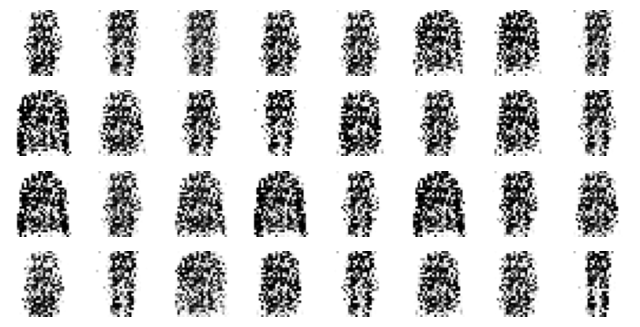

Epoch 2/5


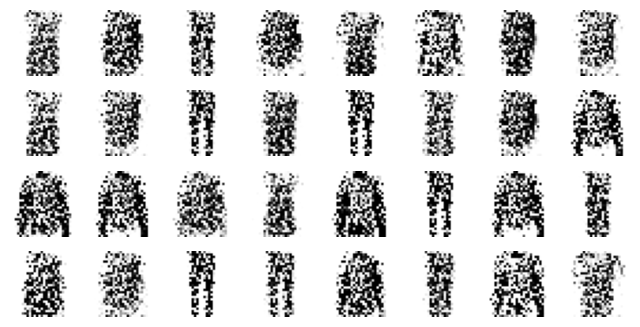

Epoch 3/5


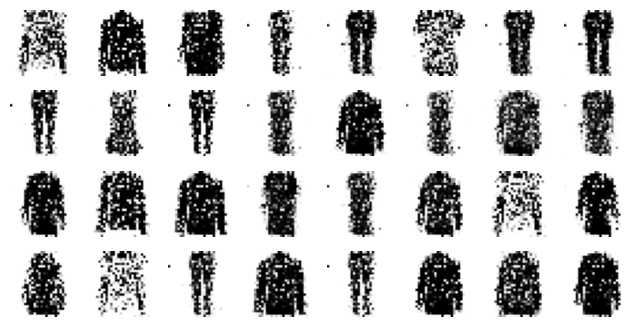

Epoch 4/5


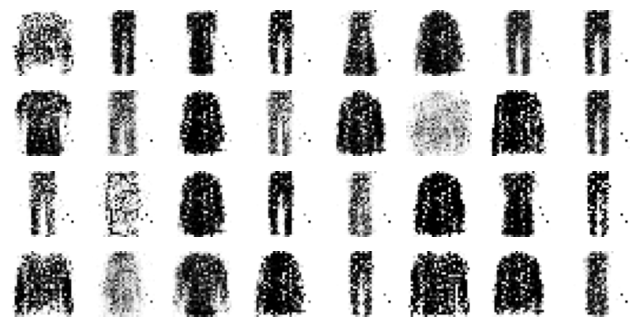

Epoch 5/5


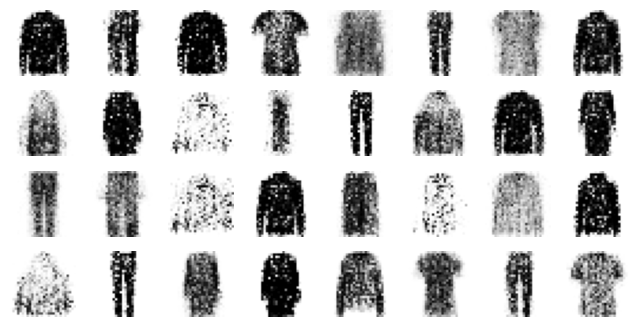

In [8]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

In [ ]:
tf.random.set_seed(42)

In [9]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 128ms/step


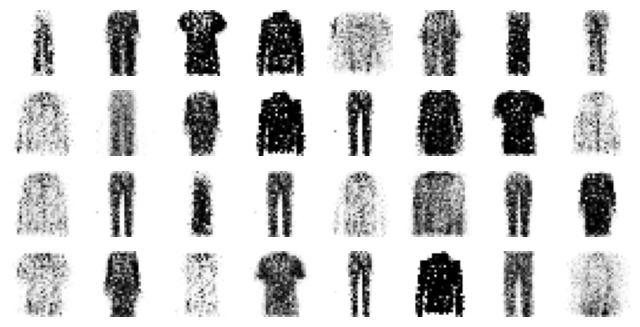

In [10]:
plot_multiple_images(generated_images, 8)
plt.show()

# Deep Convolutional GAN

In [11]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [12]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [13]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

Note: The number of epochs was changed from 5 to 50 below due to training time of a CPU. Training for 50 epochs results in better images.

Epoch 1/5


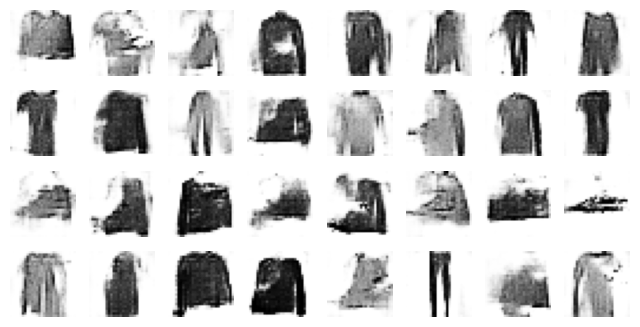

Epoch 2/5


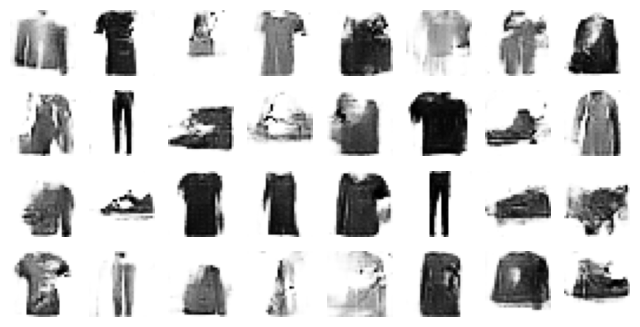

Epoch 3/5


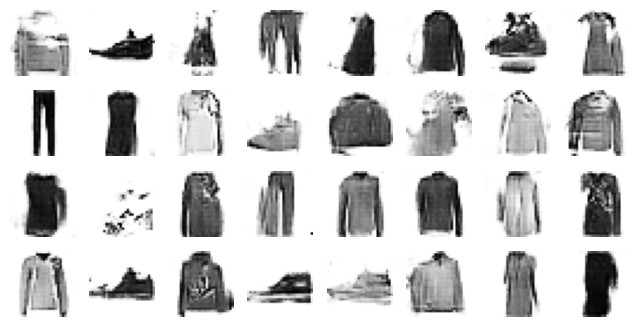

Epoch 4/5


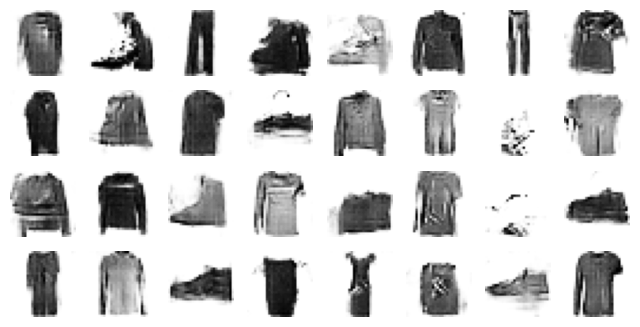

Epoch 5/5


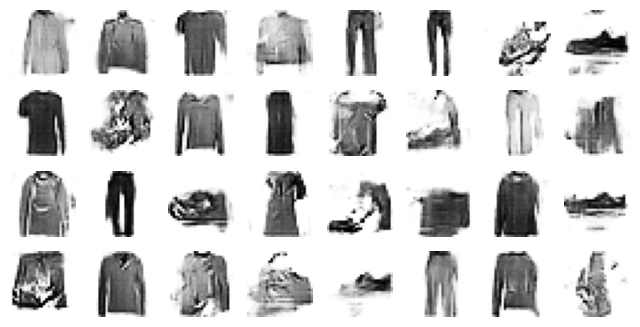

In [14]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

1/1 [==============================] - 0s 99ms/step


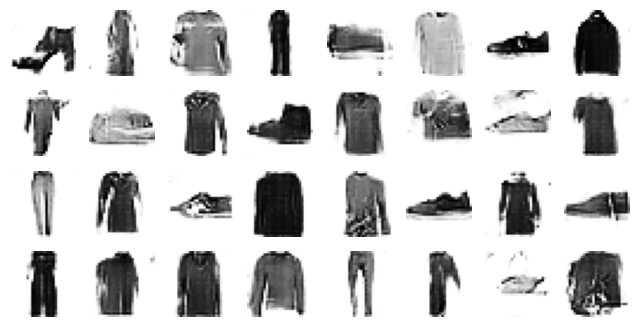

In [15]:
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)